# Heart Attack Prediction

The goal of this notebook is to train and compare machine learning models on heart attack prediction dataset.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay, roc_curve
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

OUTPUT_COLUMN = "output"

## Get and analyze the data

Data from https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset
(to run this notebook you will need to manually download `heart.csv` from the link):
- Age : Age of the patient
- Sex : Sex of the patient
- exang: exercise induced angina (1 = yes; 0 = no)
- ca: number of major vessels (0-3)
- cp : Chest Pain type chest pain type
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
- trtbps : resting blood pressure (in mm Hg)
- chol : cholestoral in mg/dl fetched via BMI sensor
- fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- rest_ecg : resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- thalach : maximum heart rate achieved
- target : 0= less chance of heart attack 1= more chance of heart attack

In [2]:
df = pd.read_csv("heart.csv")
df

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


### One hot encode data.
The values for cp (chest pain) and rest_ecg are not ordered in some meaningful way (e.g. higher value -> bigger pain).
Therefore one hot encoding is especially relevant for Logistic Regression model.
Without this, the mentioned model would pick up (and would be restricted) by the order of values cp and res_ecg: $$\hat{y} = \beta_0 + ... + \beta_i cp + ... + \beta_j restecg + ...$$

In [3]:
df = pd.get_dummies(df, columns=["cp", "restecg"])
df

,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,slp,caa,thall,output,cp_0,cp_1,cp_2,cp_3,restecg_0,restecg_1,restecg_2
0,63,1,145,233,1,150,0,2.3,0,0,1,1,0,0,0,1,1,0,0
1,37,1,130,250,0,187,0,3.5,0,0,2,1,0,0,1,0,0,1,0
2,41,0,130,204,0,172,0,1.4,2,0,2,1,0,1,0,0,1,0,0
3,56,1,120,236,0,178,0,0.8,2,0,2,1,0,1,0,0,0,1,0
4,57,0,120,354,0,163,1,0.6,2,0,2,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,140,241,0,123,1,0.2,1,0,3,0,1,0,0,0,0,1,0
299,45,1,110,264,0,132,0,1.2,1,0,3,0,0,0,0,1,0,1,0
300,68,1,144,193,1,141,0,3.4,1,2,3,0,1,0,0,0,0,1,0
301,57,1,130,131,0,115,1,1.2,1,1,3,0,1,0,0,0,0,1,0


### Correlation heatmap

<AxesSubplot: >

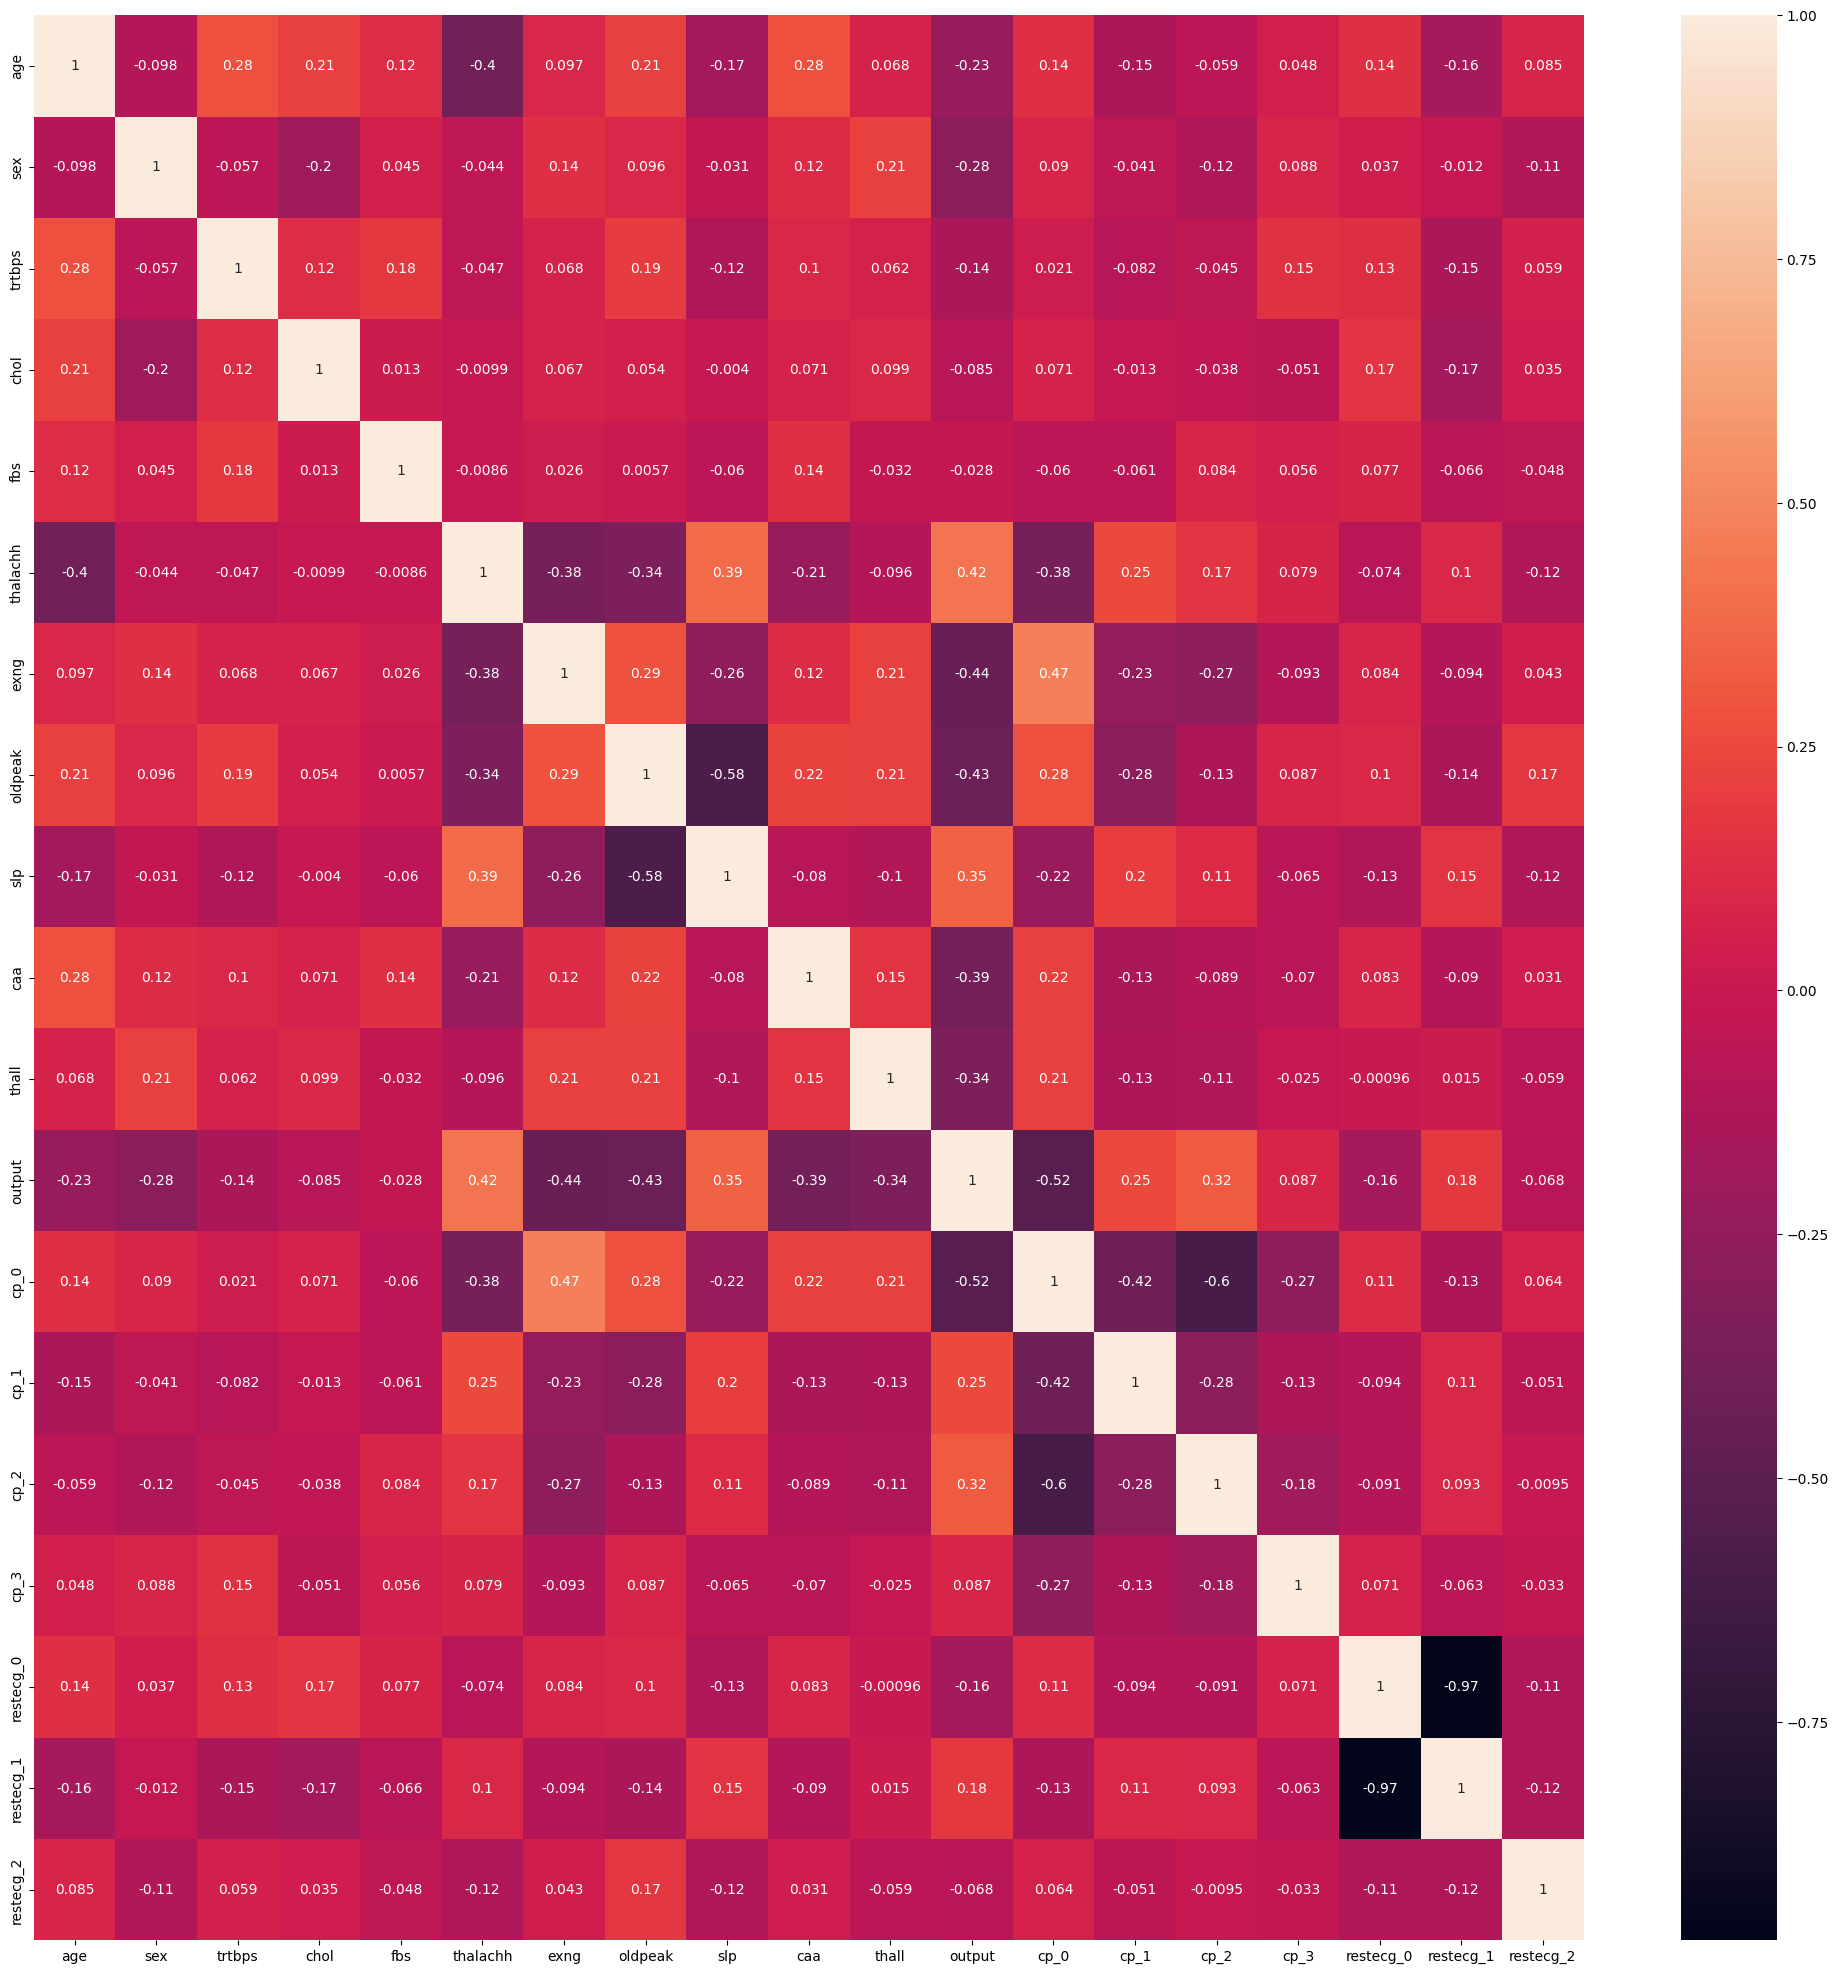

In [4]:
plt.figure(figsize=(25, 25))
sns.heatmap(df.corr(), annot=True)

On the above plot we can see that there are indeed highly correlated/anticorrelated features (e.g. thalachh 0.42, exng -0.44, ddpeak -0.43, cp_0 -0.52) with the output.
Therefore we can expect the models to work on the dataset.

### Prepare the data
Split data into train and test dataset, and standardize the data.
Standardization is not required for tree based approaches but it is useful for Logistic Regression when using some kind of penalty (L2, L1, elasticnet).

In [5]:
scaler = StandardScaler()

X, y = df.drop(columns=[OUTPUT_COLUMN]), df[OUTPUT_COLUMN]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Train models and evaluate

In [6]:
models = [GradientBoostingClassifier(), RandomForestClassifier(), LogisticRegression()]
scores = [accuracy_score, roc_auc_score]

for m in models:
    m.fit(X_train, y_train)
    print(f"{str(m): >30}:", end=" ")
    for s, y_hat in zip(scores, (m.predict(X_test), m.predict_proba(X_test)[:, 1])):
        print(f"{s.__name__}={s(y_test, y_hat):.3f}", end=" ")
    print()

  GradientBoostingClassifier(): accuracy_score=0.830 roc_auc_score=0.878 
      RandomForestClassifier(): accuracy_score=0.820 roc_auc_score=0.906 
          LogisticRegression(): accuracy_score=0.800 roc_auc_score=0.867 


### ROC curves

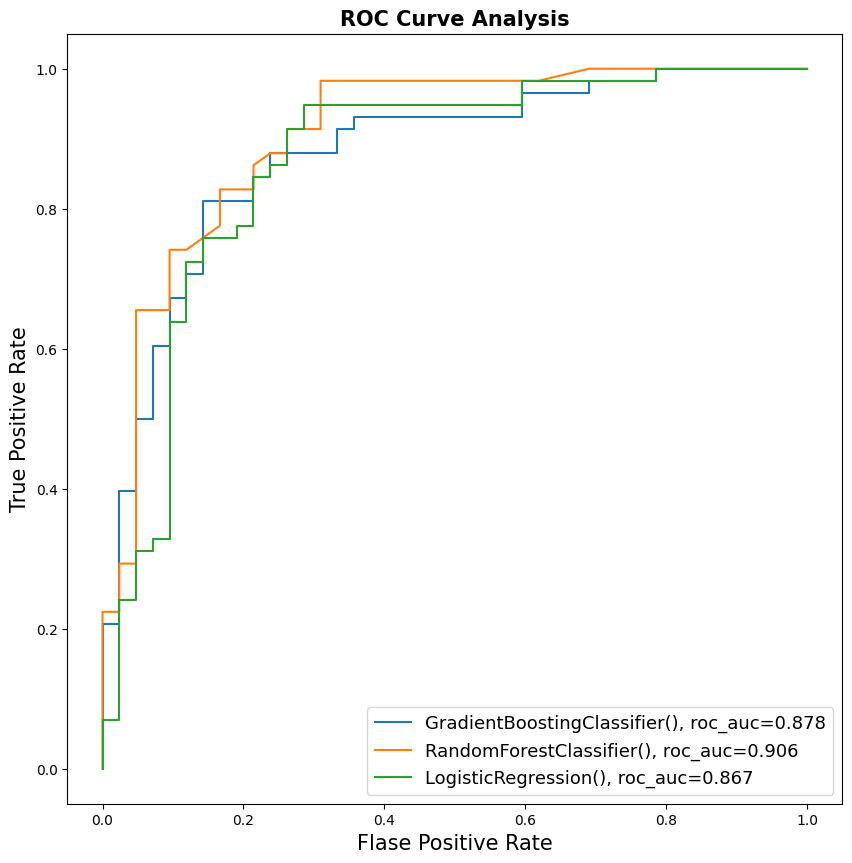

In [7]:
plt.figure(figsize=(10, 10))

for m in models:
    y_hat = m.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_hat)
    roc_auc = roc_auc_score(y_test, y_hat)
    plt.plot(fpr, tpr, label=f"{m}, {roc_auc=:.3f}")

plt.xlabel("Flase Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("ROC Curve Analysis", fontweight="bold", fontsize=15)
plt.legend(prop={"size": 13}, loc="lower right")


From the above plot we can read that LogisticRegression had significantly more false positives with high confidence than the other two models (see horizontal fragment of green curve around 0.15 FPR and 0.35 TPR). GradientBoosting, on the other hand, had more false negatives but the confidence was not that high in these mistakes (see blue curve under other curves around 0.95 TPR). The above plot also suggests that RandomForestClassifier is just overall better (orange curve is above other curves almost in all points).

### Summary

All 3 models achieved good performance (accuracy >= 80%) but the LogisticRegression was significantly worse than the other two. However looking at the ROC AUC score we can see that actually the RandomForestClassifier was significantly better than other two.